In [2]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import and Preprocess/Format Data

In [2]:
# Function which does everything below at once
def open_format_data(filename):
  # Save data from txt into list
  f = open(filename, "r")

  list_data = []
  for x in f:
      list_data.append(f.readline().rstrip().split("\t"))

  # Load list into dataframe
  column_names = ['label', "sentence"]
  df = pd.DataFrame(list_data, columns= column_names)
  df.head(10)

  # Drop any null values
  df = df.dropna()

  # Drop duplicates
  df = df.drop_duplicates()

  # Append number representing label as code
  df.label = pd.Categorical(df.label)
  df['code'] = df.label.cat.codes
  return df

In [3]:
df = open_format_data("train.txt")

In [ ]:
# Save data from txt into list
f = open("/content/drive/My Drive/Griffith/Data Mining/train.txt", "r")

list_data = []
for x in f:
    list_data.append(f.readline().rstrip().split("\t"))

print(list_data[:5])

In [ ]:
# Load list into dataframe
column_names = ['label', "sentence"]
df = pd.DataFrame(list_data, columns= column_names)
df.head(10)

In [ ]:
# Count all null values
df.isna().sum()

In [ ]:
# Drop any null values
df = df.dropna()
df.isna().sum()

In [ ]:
# Detect duplicates
df.duplicated().sum()

In [ ]:
# Drop duplicates
df = df.drop_duplicates()
df.duplicated().sum()

In [ ]:
# Append number representing label as code
df.label = pd.Categorical(df.label)
df['code'] = df.label.cat.codes
df.head()

# Data Exploration

In [ ]:
df.count()

In [ ]:
df.dtypes

In [ ]:
df.groupby("label").count()

In [ ]:
df.groupby("label")['sentence'].count().plot.bar()
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

# Tensorflow Data Formatting and Encoding

In [65]:
# Load into tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((df.sentence, df.code))
for b in train_dataset.take(5):
  print(b)

(<tf.Tensor: shape=(), dtype=string, numpy=b'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .'>, <tf.Tensor: shape=(), dtype=int8, numpy=3>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .'>, <tf.Tensor: shape=(), dtype=int8, numpy=2>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .'>, <tf.Tensor: shape=(), dtype=int8, numpy=2>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'There was a clinically relevant reduction in the intervention group compare

In [66]:
# Generate vocab
tokenizer = tfds.features.text.Tokenizer()

vocabulary_set = set()
for text_tensor, _ in train_dataset:
  some_tokens = tokenizer.tokenize(text_tensor.numpy())
  vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)
# Increase vocab size for padding value (0)
vocab_size += 1
vocab_size

NameError: name 'tfds' is not defined

In [ ]:
# Setup encoder
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

def encode(text_tensor, label):
  encoded_text = encoder.encode(text_tensor.numpy())
  return encoded_text, label

def encode_map_fn(text, label):
  # py_func doesn't set the shape of the returned tensors.
  encoded_text, label = tf.py_function(encode, 
                                       inp=[text, label], 
                                       Tout=(tf.int64, tf.int8))

  # `tf.data.Datasets` work best if all components have a shape set
  #  so set the shapes manually: 
  encoded_text.set_shape([None])
  label.set_shape([])

  return encoded_text, label

In [ ]:
example_text = next(iter(train_dataset))[0].numpy()
example_text = next(iter(train_dataset))[0].numpy()
print(example_text)
encoded_example = encoder.encode(example_text)
print(encoded_example)

In [ ]:
# Encode sentences
all_encoded_data = train_dataset.map(encode_map_fn)
for ex in all_encoded_data.take(5):
  print(ex)

In [ ]:
# Shuffle into train/test data and add 
BUFFER_SIZE = 50000
BATCH_SIZE = 64
TAKE_SIZE = 2000

train_data = all_encoded_data.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE)

test_data = all_encoded_data.take(TAKE_SIZE)
test_data = test_data.padded_batch(BATCH_SIZE)

In [ ]:
sample_text, sample_labels = next(iter(train_data))

sample_text[0], encoder.decode(sample_text[0].numpy()), sample_labels[0]

# Tensorflow Basic Model

In [ ]:
# Build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 64))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))

# One or more dense layers.
# Edit the list in the `for` line to experiment with layer sizes.
for units in [64, 64]:
  model.add(tf.keras.layers.Dense(units, activation='relu'))

# Output layer. The first argument is the number of labels.
model.add(tf.keras.layers.Dense(5))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(train_data, epochs=3, validation_data=test_data)

In [ ]:
eval_loss, eval_acc = model.evaluate(test_data)

print('\nEval loss: {:.3f}, Eval accuracy: {:.3f}'.format(eval_loss, eval_acc))

# Tensorflow Word Embedding

In [ ]:
embedding_layer = layers.Embedding(1000, 5)
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

In [64]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(5)
])

model.summary()

NameError: name 'vocab_size' is not defined

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_data,
    epochs=3,
    validation_data=test_data, validation_steps=20)

In [ ]:
# Retrive the learned embeddings
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

# Save to disk
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.tokens):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

# Download to PC
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

# SciBERT Model For Sentence Embeddings


In [68]:
from transformers import BertModel, BertTokenizer
import torch
import numpy as np

In [69]:
scibert_model = BertModel.from_pretrained("allenai/scibert_scivocab_uncased",
                                  output_hidden_states=True)
scibert_tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

print('scibert_tokenizer is type:', type(scibert_tokenizer))
print('    scibert_model is type:', type(scibert_model))

scibert_tokenizer is type: <class 'transformers.tokenization_bert.BertTokenizer'>
    scibert_model is type: <class 'transformers.modeling_bert.BertModel'>


In [80]:
def get_embedding(model, tokenizer, text):

    # Encode with special tokens ([CLS] and [SEP], returning pytorch tensors
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        return_tensors = 'pt'
                )

    input_ids = encoded_dict['input_ids']
    
    # Set model to evaluation mode
    model.eval()
    
    # Run through BERT
    with torch.no_grad():

        outputs = model(input_ids)

        # Extract hidden states
        hidden_states = outputs[2]

    # Select the embeddings
    token_vecs = hidden_states[-2][0]

    # Calculate average of token vectors
    sentence_embedding = torch.mean(token_vecs, dim=0)

    # Convert to np array
    sentence_embedding = sentence_embedding.detach().numpy()

    return sentence_embedding

In [10]:
from IPython.display import clear_output
import timeit

embeddings = []
length = len(df['sentence'].tolist())
index = 0

start = timeit.default_timer()
for sentence in df['sentence'].tolist():
    clear_output(wait=True)
    index += 1
    sen_emb = get_embedding(scibert_model, scibert_tokenizer, sentence)
    embeddings.append(sen_emb)

    stop = timeit.default_timer()

    if (index/length*100) < 1:
        expected_time = "Calculating..."

    else:
        time_perc = timeit.default_timer()
        expected_time = np.round( (time_perc-start) /(index/length) /60,2)

    print(index, length)
    print(expected_time)

print(len(embeddings))

88797 88797
139.64
88797


In [11]:
df.head()

,label,sentence,code
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,3
1,METHODS,Outcome measures included pain reduction and i...,2
2,METHODS,Secondary outcome measures included the Wester...,2
3,RESULTS,There was a clinically relevant reduction in t...,4
4,RESULTS,"Further , there was a clinically relevant redu...",4


In [12]:
df['scibert'] = embeddings
df.head()

,label,sentence,code,scibert
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,3,"[-0.44510403, -0.31423956, -0.45745727, 0.4200..."
1,METHODS,Outcome measures included pain reduction and i...,2,"[-0.4775299, -0.46893463, -0.22414015, 0.22520..."
2,METHODS,Secondary outcome measures included the Wester...,2,"[-0.61925375, -0.19193889, -0.38404435, 0.2082..."
3,RESULTS,There was a clinically relevant reduction in t...,4,"[-0.5922383, -0.41908544, -0.33248687, 0.55146..."
4,RESULTS,"Further , there was a clinically relevant redu...",4,"[-0.38201377, -0.53494513, 0.1772025, 0.381558..."


In [13]:
# Save dataframe to prevent recalculation
df.to_pickle("./df_embeddings.pkl")

# Investigating SciBert Embedded Models

In [7]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
df = pd.read_pickle("./df_embeddings.pkl")
df.head(20)

,label,sentence,code,scibert
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,3,"[-0.44510403, -0.31423956, -0.45745727, 0.4200..."
1,METHODS,Outcome measures included pain reduction and i...,2,"[-0.4775299, -0.46893463, -0.22414015, 0.22520..."
2,METHODS,Secondary outcome measures included the Wester...,2,"[-0.61925375, -0.19193889, -0.38404435, 0.2082..."
3,RESULTS,There was a clinically relevant reduction in t...,4,"[-0.5922383, -0.41908544, -0.33248687, 0.55146..."
4,RESULTS,"Further , there was a clinically relevant redu...",4,"[-0.38201377, -0.53494513, 0.1772025, 0.381558..."
5,RESULTS,The Outcome Measures in Rheumatology Clinical ...,4,"[0.027787112, 0.23189485, -0.3841277, 0.625988..."
7,BACKGROUND,Emotional eating is associated with overeating...,0,"[-0.6055013, -0.14416914, -0.32580143, 0.12642..."
8,OBJECTIVE,The aim of this study was to test if attention...,3,"[-0.37356007, 0.10462127, -0.011478976, -0.169..."
9,METHODS,Participants ( N = @ ) were randomly assigned ...,2,"[0.23434164, 0.32432234, -0.29593608, -0.39225..."
10,METHODS,Self-reported emotional eating was assessed wi...,2,"[-0.65840876, 0.21802892, -0.24623804, -0.1824..."


In [88]:
# Export to weka
export_df = pd.DataFrame(df['scibert'][:2500].tolist(), index=df.index[:2500])
export_df['label'] = df['label'][:2500]

export_df.to_csv('./weka.csv', index=False)

export_df = pd.DataFrame(df['scibert'][2500:3500].tolist(), index=df.index[2500:3500])
export_df['label'] = df['label'][2500:3500]
export_df.to_csv('./weka_test.csv', index=False)

          0         1         2         3         4         5         6  \
0 -0.445104 -0.314240 -0.457457  0.420030  0.173084 -0.065855  0.061035   
1 -0.477530 -0.468935 -0.224140  0.225207 -0.628368 -0.186920  0.422231   
2 -0.619254 -0.191939 -0.384044  0.208252 -0.608025  0.478259  0.203383   
3 -0.592238 -0.419085 -0.332487  0.551465 -0.382408 -0.024462  0.144854   
4 -0.382014 -0.534945  0.177202  0.381558 -0.054668  0.454776 -0.134878   

          7         8         9  ...       759       760       761       762  \
0  0.711958  0.052800 -0.041667  ...  0.480911 -0.697301 -0.227034  0.044675   
1  1.097500 -0.643063  0.386619  ...  0.211434 -0.202346 -0.248359  0.104181   
2  0.504245 -0.398351  0.235902  ... -0.013601 -0.074485 -0.533143 -0.200412   
3  0.251451 -0.027627 -0.236988  ...  0.349020 -0.284310 -0.204176  0.287185   
4  0.459382  0.098035 -0.291524  ...  0.331686 -0.720776 -0.054727  0.102350   

        763       764       765       766       767      label  
0 -

In [4]:
# Weka Metrics
labels = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]
conf_matrix = [[72, 12, 13, 28, 2], 
               [18, 99, 7, 7, 28], 
               [6, 0, 306, 10, 18],
               [16, 7, 10, 33, 0],
               [ 1, 4, 16, 0, 287]]
df_cm = pd.DataFrame(conf_matrix, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,2))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, fmt='d', cmap="Blues", annot=True, annot_kws={"size": 12})# font size
plt.show()

NameError: name 'sns' is not defined

<Figure size 288x144 with 0 Axes>

In [5]:
# Sample even number from each class
even_df = df.groupby('code').apply(lambda x: x.sample(n=500)).reset_index(drop = True)
even_test = df.groupby('code').apply(lambda x: x.sample(n=200)).reset_index(drop = True)
even_df.groupby("label").count()

,sentence,code,scibert
label,,,
BACKGROUND,500,500,500
CONCLUSIONS,500,500,500
METHODS,500,500,500
OBJECTIVE,500,500,500
RESULTS,500,500,500


Time elapsed: 77.28767180099749
F1 Score
0.8222010746895864
MCC
0.7610562304480429
Accuracy
0.8227
              precision    recall  f1-score   support

  BACKGROUND       0.59      0.62      0.61      1092
 CONCLUSIONS       0.74      0.77      0.76      1501
     METHODS       0.89      0.92      0.90      3260
   OBJECTIVE       0.65      0.56      0.60       819
     RESULTS       0.91      0.88      0.90      3328

    accuracy                           0.82     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.82      0.82      0.82     10000



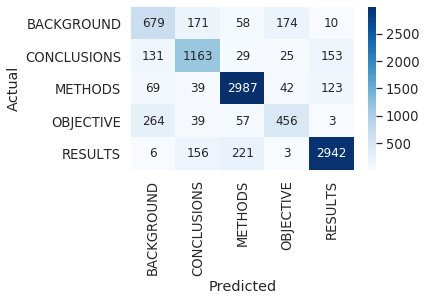

In [73]:
# kNN with scikit-learn
import timeit
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(8, metric="manhattan", n_jobs=-1)
# Fit models
start = timeit.default_timer()
model.fit(df['scibert'][:2500].tolist(), df['label'][:2500].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())
stop = timeit.default_timer()
print("Time elapsed:", stop-start)
# Evaluate
print("F1 Score")
print(f1_score(df['label'][2500:3500].tolist(), pred, average="weighted"))
print("MCC")
print(matthews_corrcoef(df['label'][2500:3500].tolist(), pred))
print("Accuracy")
print(accuracy_score(df['label'][2500:3500].tolist(), pred))
print(classification_report(df['label'][2500:3500].tolist(), pred))
# Confusion Matrix
labels = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]
conf_matrix = confusion_matrix(df['label'][2500:3500].tolist(), pred, labels=labels)
# perc_matrix = conf_matrix/np.sum(conf_matrix)
df_cm = pd.DataFrame(conf_matrix, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, fmt='d', cmap="Blues", annot=True, annot_kws={"size": 12})# font size
plt.show()

In [62]:
# kNN from scratch
import timeit
import heapq

def knn(k, test_data, train_data, train_label):
    pred = []
    # Iterate over each input data case
    for test_embedding in test_data[:20]:
        # List to hold (distance, label)
        distances = []
        # Calculate distance of data point from each train_data case
        for i in range(len(train_data)):
            manhattan_dist = 0
            # Iterate over each dimension of the embedding
            for x in range(len(test_embedding)):
                manhattan_dist += abs(test_embedding[x] - train_data[i][x])
            # Append (distance, label)
            distances.append((manhattan_dist, train_label[i]))
        # Find k-nearest neighbors
        k_smallest = heapq.nsmallest(k, distances)
        # Select just labels
        labels = [lis[1] for lis in k_smallest]
        # Find mode (in tie will select first appearing neighbor)
        label = max(set(labels), key=labels.count)
        pred.append(label)
    return pred
            
train_data = df['scibert'][:2500].tolist()
train_label = df['code'][:2500].tolist()
test_data = df['scibert'][2500:3500].tolist()
test_labels = df['code'][2500:3500].tolist()

# Run knn
start = timeit.default_timer()
pred = knn(5, test_data, train_data, train_label)
stop = timeit.default_timer()
print("Time elapsed:", stop-start)

# Evaluate
# print("F1 Score")
# print(f1_score(test_labels[:20], pred, average="macro"))
# print("MCC")
# print(matthews_corrcoef(test_labels[:20], pred))
# print("Accuracy")
# print(accuracy_score(test_labels[:20], pred))
# print(confusion_matrix(test_labels[:20], pred))

Time elapsed: 20.33666393800013


Time elapsed: 14.909251436001796
F1 Score
0.7909139951332381
MCC
0.721058165887981
Accuracy
0.793
              precision    recall  f1-score   support

           0       0.58      0.62      0.60       127
           1       0.75      0.65      0.70       159
           2       0.89      0.89      0.89       340
           3       0.45      0.41      0.43        66
           4       0.87      0.92      0.89       308

    accuracy                           0.79      1000
   macro avg       0.71      0.70      0.70      1000
weighted avg       0.79      0.79      0.79      1000



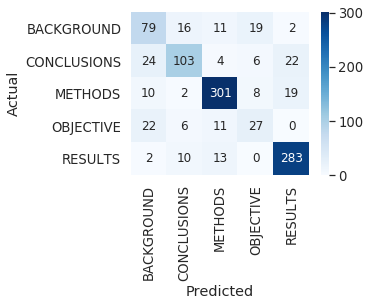

In [71]:
# kNN improved with numpy
import timeit
import heapq
# import Numpy for more efficient manhattan distance
import numpy as np

def knn(k, test_data, train_data, train_label):
    test_arr = np.array(test_data)
    train_arr = np.array(train_data)
    pred = []
    # Iterate over each input data case
    for test_embedding in test_arr:
        # List to hold (distance, label)
        distances = []
        # Calculate distance of data point from each train_data case
        for i in range(len(train_arr)):
            manhattan_dist = np.sum(np.abs(test_embedding-train_arr[i]))
            # Append (distance, label)
            distances.append((manhattan_dist, train_label[i]))
        # Find k-nearest neighbors
        k_smallest = heapq.nsmallest(k, distances)
        # Select just labels
        labels = [lis[1] for lis in k_smallest]
        # Find mode (in tie will select first appearing neighbor)
        label = max(set(labels), key=labels.count)
        pred.append(label)
    return pred
            
train_data = df['scibert'][:2500].tolist()
train_label = df['code'][:2500].tolist()
test_data = df['scibert'][2500:3500].tolist()

# Run knn
start = timeit.default_timer()
pred = knn(8, test_data, train_data, train_label)
stop = timeit.default_timer()
print("Time elapsed:", stop-start)

# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="weighted"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print(classification_report(df['code'][2500:3500].tolist(), pred))
# Confusion Matrix
labels = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]
conf_matrix = confusion_matrix(df['code'][2500:3500].tolist(), pred)
# perc_matrix = conf_matrix/np.sum(conf_matrix)
df_cm = pd.DataFrame(conf_matrix, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,3))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, fmt='d', cmap="Blues", annot=True, annot_kws={"size": 12})# font size
plt.show()

0.7209589174287585
0.6491160423761841
0.719
              precision    recall  f1-score   support

  BACKGROUND       0.58      0.57      0.58       200
 CONCLUSIONS       0.70      0.71      0.71       200
     METHODS       0.86      0.80      0.83       200
   OBJECTIVE       0.63      0.70      0.67       200
     RESULTS       0.85      0.81      0.83       200

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



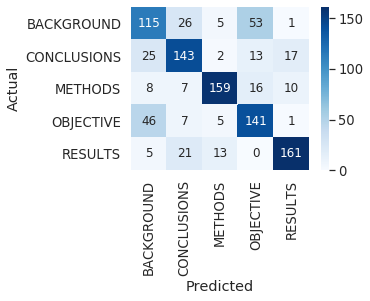

In [9]:
# KNN with balanced data
train_data = even_df['scibert'].tolist()
train_labels = even_df['label'].tolist()
test_data = even_test['scibert'].tolist()
test_labels = even_test['label'].tolist()

from sklearn.neighbors import KNeighborsClassifier
model_even = KNeighborsClassifier(metric="manhattan", n_jobs=-1)
model_even.fit(train_data, train_labels)
pred_even = model_even.predict(test_data)

print(f1_score(test_labels, pred_even, average="macro"))
print(matthews_corrcoef(test_labels, pred_even))
print(accuracy_score(test_labels, pred_even))
print(classification_report(test_labels, pred_even))
# Confusion Matrix
labels = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]
conf_matrix = confusion_matrix(test_labels, pred_even)
# perc_matrix = conf_matrix/np.sum(conf_matrix)
df_cm = pd.DataFrame(conf_matrix, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,3))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, fmt='d', cmap="Blues", annot=True, annot_kws={"size": 12})# font size
plt.show()

In [7]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
model_even = BernoulliNB()
# Fit models
model.fit(df['scibert'][:2500].tolist(), df['code'][:2500].tolist())
model_even.fit(even_df['scibert'].tolist(), even_df['code'].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())
pred_even = model_even.predict(df['scibert'][2500:3500].tolist())
# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="macro"))
print(f1_score(df['code'][2500:3500].tolist(), pred_even, average="macro"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred_even))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print(accuracy_score(df['code'][2500:3500].tolist(), pred_even))

F1 Score
0.6681035538397584
0.6709305896250097
MCC
0.6634952331940656
0.6558606143364742
Accuracy
0.747
0.741


In [8]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model_even = GaussianNB()
# Fit models
model.fit(df['scibert'][:2500].tolist(), df['code'][:2500].tolist())
model_even.fit(even_df['scibert'].tolist(), even_df['code'].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())
pred_even = model_even.predict(df['scibert'][2500:3500].tolist())
# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="macro"))
print(f1_score(df['code'][2500:3500].tolist(), pred_even, average="macro"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred_even))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print(accuracy_score(df['code'][2500:3500].tolist(), pred_even))

F1 Score
0.6969765214942665
0.680103550567688
MCC
0.6918251118653097
0.6686883947774092
Accuracy
0.767
0.75


In [9]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model_even = DecisionTreeClassifier()
# Fit models
model.fit(df['scibert'][:2500].tolist(), df['code'][:2500].tolist())
model_even.fit(even_df['scibert'].tolist(), even_df['code'].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())
pred_even = model_even.predict(df['scibert'][2500:3500].tolist())
# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="macro"))
print(f1_score(df['code'][2500:3500].tolist(), pred_even, average="macro"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred_even))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print(accuracy_score(df['code'][2500:3500].tolist(), pred_even))

F1 Score
0.46094697692739006
0.4676075892099999
MCC
0.4103338396416756
0.38655254976388786
Accuracy
0.559
0.525


In [10]:
from sklearn.svm import LinearSVC
model = LinearSVC(multi_class="ovr", max_iter=1000)
model_even = LinearSVC(multi_class="ovr", max_iter=1000)
# Fit models
model.fit(df['scibert'][:2500].tolist(), df['code'][:2500].tolist())
model_even.fit(even_df['scibert'].tolist(), even_df['code'].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())
pred_even = model_even.predict(df['scibert'][2500:3500].tolist())
# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="macro"))
print(f1_score(df['code'][2500:3500].tolist(), pred_even, average="macro"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred_even))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print(accuracy_score(df['code'][2500:3500].tolist(), pred_even))

/home/connor/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


F1 Score
0.6931498071426793
0.6671190236890402
MCC
0.7125171448205804
0.6789894636994003
Accuracy
0.787
0.758


/home/connor/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


F1 Score
0.8361704245772058
MCC
0.7866132899786072
Accuracy
0.842
              precision    recall  f1-score   support

  BACKGROUND       0.62      0.70      0.66       127
 CONCLUSIONS       0.85      0.74      0.79       159
     METHODS       0.90      0.95      0.92       340
   OBJECTIVE       0.55      0.33      0.42        66
     RESULTS       0.91      0.94      0.93       308

    accuracy                           0.84      1000
   macro avg       0.77      0.73      0.74      1000
weighted avg       0.84      0.84      0.84      1000



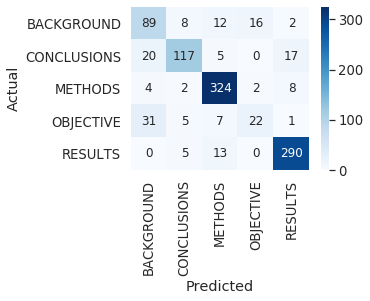

In [14]:
from sklearn.svm import SVC
model = SVC(kernel='rbf', gamma=0.02, C=2)
# Fit models
model.fit(df['scibert'][:2500].tolist(), df['label'][:2500].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())

# Evaluate
print("F1 Score")
print(f1_score(df['label'][2500:3500].tolist(), pred, average="weighted"))
print("MCC")
print(matthews_corrcoef(df['label'][2500:3500].tolist(), pred))
print("Accuracy")
print(accuracy_score(df['label'][2500:3500].tolist(), pred))
print(classification_report(df['label'][2500:3500].tolist(), pred))
# Confusion Matrix
labels = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]
conf_matrix = confusion_matrix(df['label'][2500:3500].tolist(), pred)
# perc_matrix = conf_matrix/np.sum(conf_matrix)
df_cm = pd.DataFrame(conf_matrix, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,3))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, fmt='d', cmap="Blues", annot=True, annot_kws={"size": 12})# font size
plt.show()

F1 Score
0.8550125317616566
MCC
0.8059755465029053
Accuracy
0.8562
              precision    recall  f1-score   support

  BACKGROUND       0.66      0.68      0.67      1092
 CONCLUSIONS       0.84      0.83      0.83      1501
     METHODS       0.89      0.95      0.92      3260
   OBJECTIVE       0.72      0.61      0.66       819
     RESULTS       0.93      0.90      0.91      3328

    accuracy                           0.86     10000
   macro avg       0.81      0.79      0.80     10000
weighted avg       0.86      0.86      0.86     10000



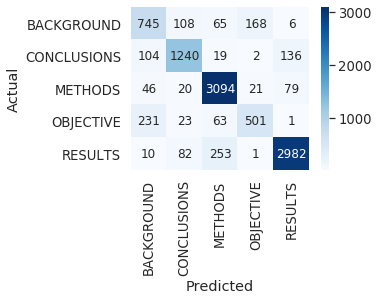

In [12]:
from sklearn.svm import SVC
model = SVC()
# Fit models
model.fit(df['scibert'][:25000].tolist(), df['label'][:25000].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][25000:35000].tolist())

# Evaluate
print("F1 Score")
print(f1_score(df['label'][25000:35000].tolist(), pred, average="weighted"))
print("MCC")
print(matthews_corrcoef(df['label'][25000:35000].tolist(), pred))
print("Accuracy")
print(accuracy_score(df['label'][25000:35000].tolist(), pred))
print(classification_report(df['label'][25000:35000].tolist(), pred))
# Confusion Matrix
labels = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]
conf_matrix = confusion_matrix(df['label'][25000:35000].tolist(), pred)
# perc_matrix = conf_matrix/np.sum(conf_matrix)
df_cm = pd.DataFrame(conf_matrix, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,3))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, fmt='d', cmap="Blues", annot=True, annot_kws={"size": 12})# font size
plt.show()

F1 Score
0.8627758978544143
MCC
0.8165048908888648
Accuracy
0.8639
              precision    recall  f1-score   support

  BACKGROUND       0.66      0.72      0.69      1092
 CONCLUSIONS       0.84      0.84      0.84      1501
     METHODS       0.90      0.95      0.93      3260
   OBJECTIVE       0.74      0.59      0.66       819
     RESULTS       0.94      0.90      0.92      3328

    accuracy                           0.86     10000
   macro avg       0.82      0.80      0.81     10000
weighted avg       0.86      0.86      0.86     10000



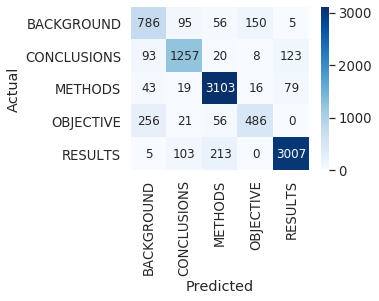

In [13]:
from sklearn.svm import SVC
model = SVC(kernel='rbf', gamma=0.02, C=2)
# Fit models
model.fit(df['scibert'][:25000].tolist(), df['label'][:25000].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][25000:35000].tolist())

# Evaluate
print("F1 Score")
print(f1_score(df['label'][25000:35000].tolist(), pred, average="weighted"))
print("MCC")
print(matthews_corrcoef(df['label'][25000:35000].tolist(), pred))
print("Accuracy")
print(accuracy_score(df['label'][25000:35000].tolist(), pred))
print(classification_report(df['label'][25000:35000].tolist(), pred))
# Confusion Matrix
labels = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]
conf_matrix = confusion_matrix(df['label'][25000:35000].tolist(), pred)
# perc_matrix = conf_matrix/np.sum(conf_matrix)
df_cm = pd.DataFrame(conf_matrix, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,3))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, fmt='d', cmap="Blues", annot=True, annot_kws={"size": 12})# font size
plt.show()

In [80]:
# Even data
from sklearn.svm import SVC
model_even = SVC(kernel='rbf', gamma=0.02, C=2)
model_even.fit(even_df['scibert'].tolist(), even_df['code'].tolist())
pred_even = model_even.predict(even_test['scibert'].tolist())
print(f1_score(even_test['code'].tolist(), pred_even, average="macro"))
print(matthews_corrcoef(even_test['code'].tolist(), pred_even))
print(accuracy_score(even_test['code'].tolist(), pred_even))
print(confusion_matrix(even_test['code'].tolist(), pred_even))

0.7675276421811181
0.7119328931803347
0.769
[[127  11   9  52   1]
 [ 13 163   4   2  18]
 [  8   1 186   2   3]
 [ 55   4  15 126   0]
 [  1  14  18   0 167]]


In [31]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle


# >> FEATURE SELECTION << #
def remove_correlated_features(X):
    corr_threshold = 0.9
    corr = X.corr()
    drop_columns = np.full(corr.shape[0], False, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= corr_threshold:
                drop_columns[j] = True
    columns_dropped = X.columns[drop_columns]
    X.drop(columns_dropped, axis=1, inplace=True)
    return columns_dropped


def remove_less_significant_features(X, Y):
    sl = 0.05
    regression_ols = None
    columns_dropped = np.array([])
    for itr in range(0, len(X.columns)):
        regression_ols = sm.OLS(Y, X).fit()
        max_col = regression_ols.pvalues.idxmax()
        max_val = regression_ols.pvalues.max()
        if max_val > sl:
            X.drop(max_col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [max_col])
        else:
            break
    regression_ols.summary()
    return columns_dropped


##############################


# >> MODEL TRAINING << #
def compute_cost(W, X, Y):
    # calculate hinge loss
    N = X.shape[0]
    print(N)
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = regularization_strength * (np.sum(distances) / N)

    # calculate cost
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    return cost


# I haven't tested it but this same function should work for
# vanilla and mini-batch gradient descent as well
def calculate_cost_gradient(W, X_batch, Y_batch):
    # if only one example is passed (eg. in case of SGD)
    if type(Y_batch) == np.float64:
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])  # gives multidimensional array

    distance = 1 - (Y_batch * np.dot(X_batch, W))
    dw = np.zeros(len(W))

    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (regularization_strength * Y_batch[ind] * X_batch[ind])
        dw += di

    dw = dw/len(Y_batch)  # average
    return dw


def sgd(features, outputs):
    max_epochs = 5000
    weights = np.zeros(features.shape[1])
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        # shuffle to prevent repeating update cycles
        X, Y = shuffle(features, outputs)
        for ind, x in enumerate(X):
            ascent = calculate_cost_gradient(weights, x, Y[ind])
            weights = weights - (learning_rate * ascent)

        # convergence check on 2^nth epoch
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            cost = compute_cost(weights, features, outputs)
            print("Epoch is: {} and Cost is: {}".format(epoch, cost))
            # stoppage criterion
            if abs(prev_cost - cost) < cost_threshold * prev_cost:
                return weights
            prev_cost = cost
            nth += 1
    return weights


########################


def init():
    diag_map = {0: 1.0, 1: -1.0, 2: -1.0, 3: -1.0, 4: -1.0}

    # put features & outputs in different data frames
    Y = pd.DataFrame(df['code'][:2500].map(diag_map))
    X = pd.DataFrame(df['scibert'][:2500].tolist(), index= df.index[:2500])

    # filter features
#     remove_correlated_features(X)
#     remove_less_significant_features(X, Y)

    # normalize data for better convergence and to prevent overflow
#     X_normalized = MinMaxScaler().fit_transform(X.values)
#     X = pd.DataFrame(X_normalized)

    # insert 1 in every row for intercept b
    X.insert(loc=len(X.columns), column='intercept', value=1)

    print(X.head())
    print(Y.head())
    
    # split data into train and test set
    print("splitting dataset into train and test sets...")
    X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.2, random_state=42)

    # train the model
    print("training started...")
    W = sgd(X_train.to_numpy(), y_train.to_numpy())
    print("training finished.")
    print("weights are: {}".format(W))

    # testing the model
    print("testing the model...")
    y_train_predicted = np.array([])
    for i in range(X_train.shape[0]):
        yp = np.sign(np.dot(X_train.to_numpy()[i], W))
        y_train_predicted = np.append(y_train_predicted, yp)

    y_test_predicted = np.array([])
    for i in range(X_test.shape[0]):
        yp = np.sign(np.dot(X_test.to_numpy()[i], W))
        y_test_predicted = np.append(y_test_predicted, yp)

    print("accuracy on test dataset: {}".format(accuracy_score(y_test, y_test_predicted)))
    print("recall on test dataset: {}".format(recall_score(y_test, y_test_predicted)))
    print("precision on test dataset: {}".format(recall_score(y_test, y_test_predicted)))


# set hyper-parameters and call init
regularization_strength = 10000
learning_rate = 0.000001
init()

          0         1         2         3         4         5         6  \
0 -0.445104 -0.314240 -0.457457  0.420030  0.173084 -0.065855  0.061035   
1 -0.477530 -0.468935 -0.224140  0.225207 -0.628368 -0.186920  0.422231   
2 -0.619254 -0.191939 -0.384044  0.208252 -0.608025  0.478259  0.203383   
3 -0.592238 -0.419085 -0.332487  0.551465 -0.382408 -0.024462  0.144854   
4 -0.382014 -0.534945  0.177202  0.381558 -0.054668  0.454776 -0.134878   

          7         8         9  ...       759       760       761       762  \
0  0.711958  0.052800 -0.041667  ...  0.480911 -0.697301 -0.227034  0.044675   
1  1.097500 -0.643063  0.386619  ...  0.211434 -0.202346 -0.248359  0.104181   
2  0.504245 -0.398351  0.235902  ... -0.013601 -0.074485 -0.533143 -0.200412   
3  0.251451 -0.027627 -0.236988  ...  0.349020 -0.284310 -0.204176  0.287185   
4  0.459382  0.098035 -0.291524  ...  0.331686 -0.720776 -0.054727  0.102350   

        763       764       765       766       767  intercept  
0 -

KeyboardInterrupt: 

In [22]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class="ovr", max_iter=1000)
model_even = LogisticRegression(multi_class="ovr", max_iter=1000)
# Fit models
model.fit(df['scibert'][:2500].tolist(), df['code'][:2500].tolist())
model_even.fit(even_df['scibert'].tolist(), even_df['code'].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())
pred_even = model_even.predict(df['scibert'][2500:3500].tolist())
# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="macro"))
print(f1_score(df['code'][2500:3500].tolist(), pred_even, average="macro"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred_even))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print(accuracy_score(df['code'][2500:3500].tolist(), pred_even))
print(confusion_matrix(df['code'][2500:3500].tolist(), pred_even))

F1 Score
0.7231861816607512
0.7153398986547954
MCC
0.7527761095624504
0.7345170631965806
Accuracy
0.817
0.802
[[ 71  16   3  32   5]
 [ 16 113   3  10  17]
 [ 13   0 309   5  13]
 [ 19   6   5  35   1]
 [  1  14  18   1 274]]


In [16]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()
model_even = MLPClassifier()
# Fit models
model.fit(df['scibert'][:2500].tolist(), df['code'][:2500].tolist())
model_even.fit(even_df['scibert'].tolist(), even_df['code'].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())
pred_even = model_even.predict(df['scibert'][2500:3500].tolist())
# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="macro"))
print(f1_score(df['code'][2500:3500].tolist(), pred_even, average="macro"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred_even))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print(accuracy_score(df['code'][2500:3500].tolist(), pred_even))

F1 Score
0.7058321377086436
0.7256700391541749
MCC
0.7370274149726393
0.7448034226562301
Accuracy
0.805
0.809


In [17]:
from sklearn.linear_model import Perceptron
model = Perceptron()
model_even = Perceptron()
# Fit models
model.fit(df['scibert'][:2500].tolist(), df['code'][:2500].tolist())
model_even.fit(even_df['scibert'].tolist(), even_df['code'].tolist())
# Predictions for each model
pred = model.predict(df['scibert'][2500:3500].tolist())
pred_even = model_even.predict(df['scibert'][2500:3500].tolist())
# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="macro"))
print(f1_score(df['code'][2500:3500].tolist(), pred_even, average="macro"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred_even))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print(accuracy_score(df['code'][2500:3500].tolist(), pred_even))

F1 Score
0.6976264130136529
0.7122919005635008
MCC
0.7286235564447606
0.7298053612649003
Accuracy
0.798
0.799


In [140]:
# Tensorflow NN
import numpy as np

# Build model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(768, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Output layer. The first argument is the number of labels.
model.add(tf.keras.layers.Dense(5))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

train_em = df['scibert'][:2500]
train_em = np.array(train_em.tolist())
train_label = df['code'][:2500]
train_label = np.array(train_label.tolist())

test_em = df['scibert'][2500:3500]
test_em = np.array(test_em.tolist())
test_label = df['code'][2500:3500]
test_label = np.array(test_label.tolist())

# Fit Model
model.fit(train_em, train_label, epochs=4, validation_data=(test_em, test_label))

eval_loss, eval_acc = model.evaluate(test_em, test_label)
print('\nEval loss: {:.3f}, Eval accuracy: {:.3f}'.format(eval_loss, eval_acc))

pred = model.predict(test_em).argmax(axis=-1)

# Evaluate
print("F1 Score")
print(f1_score(df['code'][2500:3500].tolist(), pred, average="macro"))
print("MCC")
print(matthews_corrcoef(df['code'][2500:3500].tolist(), pred))
print("Accuracy")
print(accuracy_score(df['code'][2500:3500].tolist(), pred))
print("Confusion Matrix")
print(confusion_matrix(df['code'][2500:3500].tolist(), pred))

Epoch 1/4
79/79 [==============================] - 1s 13ms/step - loss: 0.7245 - accuracy: 0.7280 - val_loss: 0.5772 - val_accuracy: 0.8020
Epoch 2/4
79/79 [==============================] - 1s 8ms/step - loss: 0.4701 - accuracy: 0.8300 - val_loss: 0.5675 - val_accuracy: 0.8090
Epoch 3/4
79/79 [==============================] - 1s 9ms/step - loss: 0.3893 - accuracy: 0.8580 - val_loss: 0.6605 - val_accuracy: 0.7610
Epoch 4/4
32/32 [==============================] - 0s 3ms/step - loss: 0.5173 - accuracy: 0.8220

Eval loss: 0.517, Eval accuracy: 0.822
F1 Score
0.7312273609053561
MCC
0.7599122337675305
Accuracy
0.822
Confusion Matrix
[[ 86  12   9  16   4]
 [ 21 111   5   3  19]
 [ 10   1 319   3   7]
 [ 29   5   5  26   1]
 [  0   7  21   0 280]]


# Distillibert


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
batch_1 = df[:256]

In [ ]:
batch_1.head()

In [ ]:
batch_1['code'].value_counts()

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
# For SciBert
scibert_model = BertModel.from_pretrained("allenai/scibert_scivocab_uncased",
                                  output_hidden_states=True)
scibert_tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

print('scibert_tokenizer is type:', type(scibert_tokenizer))
print('    scibert_model is type:', type(scibert_model))

In [ ]:
tokenized = batch_1['sentence'].apply((lambda x: scibert_tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

In [ ]:
cuda = torch.device('cuda')     # Default CUDA devicecuda0
cuda0 = torch.device('cuda:0')

In [ ]:
input_ids = torch.tensor(padded)
# input_ids = input_ids.to(cuda0)
attention_mask = torch.tensor(attention_mask)
# attention_mask = attention_mask.to(cuda0)

In [ ]:
with torch.no_grad():
    features = scibert_model(input_ids, attention_mask=attention_mask)[0][:,0,:].numpy()

In [ ]:
features = last_hidden_states

In [ ]:
labels = batch_1['code']

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [ ]:
train_features.shape

In [18]:
from sklearn.neighbors import KNeighborsClassifier
lr_clf = KNeighborsClassifier()
lr_clf.fit(df['scibert'][:1000].tolist(), df['code'][:1000].tolist())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [20]:
lr_clf.score(df['scibert'][1000:2000].tolist(), df['code'][1000:2000].tolist())

0.738